## Import Packges

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization,\
 DepthwiseConv2D, LayerNormalization
from keras.layers import BatchNormalization, LayerNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
import time
import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 100
import sys

!pip install mat73
import mat73
!pip install tensorflow_addons
import tensorflow_addons as tfa

# !pip install visualkeras
# import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 5.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

topic = 'Ming/'
work_dir = '/content/gdrive/My Drive/Colab Notebooks/' + topic
import os
os.chdir(work_dir)
!pwd
save_path = work_dir

model_dir = save_path+"/DCGAN_model"
fig_path = work_dir + 'head_to_latent_fig/'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/Ming


## Define DC-GAN

In [3]:
class ConvGAN():
  def __init__(self):
    self.img_rows = 128
    self.img_cols = 128
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 16
    print(self.img_shape)
    optimizer = Adam(1e-4, 0.5)

    self.discriminator = None
    self.generator = None


In [4]:
conv_gan = ConvGAN()
# conv_gan.discriminator = tf.keras.models.load_model(model_dir+'/DCGAN_discriminator_TI_4')
# conv_gan.generator = tf.keras.models.load_model(model_dir+'/DCGAN_generator_TI_4')

conv_gan.discriminator = tf.keras.models.load_model(model_dir+'/DCGAN_discriminator_Channel_Gaussian_4')
conv_gan.generator = tf.keras.models.load_model(model_dir+'/DCGAN_generator_Channel_Gaussian_4')

# visualkeras.layered_view(conv_gan.generator).show() # display using your system viewer

(128, 128, 1)


## Load Data

In [5]:
################### transient heads ####################
field_type = 'Channel_Gaussian'
pumping_type = 'steady_state'
# data = mat73.loadmat('./Data/0719/'+field_type+'_steady_state_monitored_0719.mat')
data = mat73.loadmat('./Data/'+field_type+'_steady_state_monitored_04302023.mat')

# ################### transient heads ####################
# data = mat73.loadmat('./Data/07112022/steady_state_monitored_0711.mat')
# print(data.keys())
# pump_well_id = data['pump_well_id'].astype(int)-1
# print(pump_well_id)

# y_save = data['y_save_monitored']

# print(y_save.shape)
# print(y_save[1,1,0:1,:])
# Y_raw = y_save[:,:,1:,:]

# Y = np.zeros(Y_raw.shape)
# Y = np.delete(Y,0,axis=1)
# print(Y.shape)
# for ii in range(Y.shape[3]):
#   # print(pump_well_id[ii])
#   # print(np.argmin(Y_raw[3,:,-1,ii]))

#   Y[:,:,:,ii] = np.delete(Y_raw[:,:,:,ii],pump_well_id[ii],axis=1)
#   # print(np.sort(Y_raw[3,:,-1,ii])[:2])
#   # print(np.min(Y[3,:,-1,ii]))
# Y = Y.reshape([1000,-1])
# print(Y.shape)
# ########################################################


# X_train, X_test = X[:900], X[900:]
# Y_train, Y_test = Y[:900], Y[900:]

In [6]:
print(data.keys())
pump_well_id = data['pump_well_id'].astype(int)-1
print(pump_well_id)

y_save = data['y_save_monitored']

print(y_save.shape)

fields = data['fields'].T
# fields = np.reshape(fields,(fields.shape[0],128,128))
# fields = np.transpose(fields, (0,2,1)).reshape((fields.shape[0],-1))

print(fields.shape)
alpha = data['rv'].T
print(alpha.shape)
Y_raw = y_save
Y = np.zeros(y_save.shape)
Y = np.delete(Y,0,axis=1)
print(Y.shape)

for ii in range(Y.shape[-1]):
  # print(pump_well_id[ii])
  # print(np.argmin(Y_raw[3,:,ii]))

  Y[:,:,ii] = np.delete(Y_raw[:,:,ii],pump_well_id[ii],axis=1)
  # print(np.sort(Y_raw[3,:,ii])[:2])
  # print(np.min(Y[3,:,ii]))

NR = Y.shape[0]
Y = Y.reshape([NR,-1])
print(Y.shape)
# ########################################################

train_test_cut = int(0.9*alpha.shape[0])
X_train, X_test = alpha[:train_test_cut], alpha[train_test_cut:]
Y_train, Y_test = Y[:train_test_cut], Y[train_test_cut:]

print(X_train.shape, Y_train.shape)

dict_keys(['fields', 'pump_well_id', 'rv', 'y_save', 'y_save_monitored'])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
(5000, 25, 25)
(5000, 16384)
(5000, 16)
(5000, 24, 25)
(5000, 600)
(4500, 16) (4500, 600)


## DC-GAN Decoding & Smoothing


In [7]:
############### define domain with (0,0) at center ######
Lox, Loy = 1, 1
nx, ny = 128, 128
dx, dy = Lox/nx, Loy/ny
x = np.arange((-Lox/2+dx/2),(Lox/2),dx)
y = np.arange((-Lox/2+dx/2),(Lox/2),dy)
# Domain bounds   
lbs = np.array([min(x),min(y)])
ubs = np.array([max(x),max(y)])

Xm, Ym = np.meshgrid(x,y)

In [8]:
test_x = tf.random.normal([1,9,9,1])

kernel_size = 3  # set the filter size of Gaussian filter
h_kernel = np.array([[0, 0, 0],[2/9, 5/9, 2/9],[0, 0, 0]]) # compute the weights of the filter with the given size (and additional params)

# assuming that the shape of `kernel_weighs` is `(kernel_size, kernel_size)`
# we need to modify it to make it compatible with the number of input channels
in_channels = 1  # the number of input channels
h_kernel = np.expand_dims(h_kernel, axis=-1)
h_kernel = np.repeat(h_kernel, in_channels, axis=-1) # apply the same filter on all the input channels
h_kernel= np.expand_dims(h_kernel, axis=-1)  # for shape compatibility reasons
print(h_kernel.shape)
# define your model...

# somewhere in your model you want to apply the Gaussian blur,
# so define a DepthwiseConv2D layer and set its weights to kernel weights
h_layer = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
test_x = h_layer(test_x)
h_layer.set_weights([h_kernel])

# the rest of the model definition...

# do this BEFORE calling `compile` method of the model
print(h_layer.get_weights())
# h_layer.set_weights([h_kernel])
h_layer.trainable = False  # the weights should not change during training

v_kernel = np.array([[0, 2/9, 0],[0, 5/9, 0],[0, 2/9, 0]]) # compute the weights of the filter with the given size (and additional params)

# assuming that the shape of `kernel_weighs` is `(kernel_size, kernel_size)`
# we need to modify it to make it compatible with the number of input channels
in_channels = 1  # the number of input channels
v_kernel = np.expand_dims(v_kernel, axis=-1)
v_kernel = np.repeat(v_kernel, in_channels, axis=-1) # apply the same filter on all the input channels
v_kernel= np.expand_dims(v_kernel, axis=-1)  # for shape compatibility reasons

# define your model...

# somewhere in your model you want to apply the Gaussian blur,
# so define a DepthwiseConv2D layer and set its weights to kernel weights
v_layer = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
test_x = v_layer(test_x)
# the rest of the model definition...

# do this BEFORE calling `compile` method of the model
v_layer.set_weights([v_kernel])
v_layer.trainable = False  # the weights should not change during training


(3, 3, 1, 1)
[array([[[[0.        ]],

        [[0.        ]],

        [[0.        ]]],


       [[[0.22222222]],

        [[0.5555556 ]],

        [[0.22222222]]],


       [[[0.        ]],

        [[0.        ]],

        [[0.        ]]]], dtype=float32)]


Text(0.5, 1.0, 'Generated from GAN')

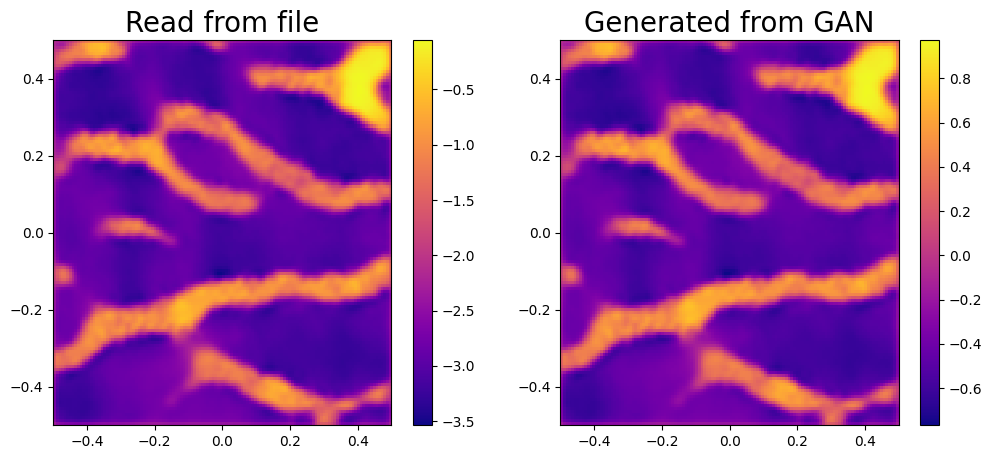

In [9]:
fid = 10

gen_imgs = conv_gan.generator.predict(X_test,verbose=0)

# for i in range(1):
#   median_filtered_img = tfa.image.median_filter2d(gen_imgs,(5,5))
# true_imgs  = median_filtered_img[:,:,:,0].numpy()

# split_val = 0.0 #np.mean(rescaled_img)
# print(split_val)
# true_imgs[true_imgs > split_val]=1.0
# true_imgs[true_imgs <=split_val]=-1.0


true_imgs = gen_imgs
for i in range(3):
  true_imgs = h_layer(true_imgs)
  true_imgs = v_layer(true_imgs)
true_imgs  = true_imgs[:,:,:,0].numpy()

fig, axs = plt.subplots(1,2,figsize=(12,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,np.reshape(fields[fid+train_test_cut], (nx,ny), order='F'), cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_title('Read from file',fontsize=20)

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,true_imgs[fid,:,:], cmap='plasma')
fig.colorbar(im, ax=ax)
ax.set_title('Generated from GAN',fontsize=20)


## Define NN

In [10]:
hidden_act = None
hidden_dim = 3000
input = Input(shape = (Y_train.shape[-1],))
# g = LayerNormalization(axis=1)(input)
g = BatchNormalization()(input)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g = Dense(hidden_dim)(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0.2)(g)

g_out = Dense(16)(g)
g_out = LayerNormalization(axis=1)(g_out)

G = Model(input, g_out, name = field_type+'_'+pumping_type)
G.summary()


alpha_loss_weight = np.ones((16,))

alpha_loss_weight /= np.linalg.norm(alpha_loss_weight)

def weighted_mse(weights=alpha_loss_weight):
  def loss(y_true, y_pred):
    squared_difference_1 = tf.square(y_true - y_pred)*weights
    total_loss = tf.reduce_mean(squared_difference_1, axis=-1)
    return total_loss
  return loss


step = tf.Variable(0, trainable=False)
boundaries = [10000, 20000]
values = [1e-3, 1e-4, 1e-5]
learning_rate_fn = PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)
# learning_rate = 0.0005
print(learning_rate)
G.compile(loss=weighted_mse(), optimizer=Adam(learning_rate, beta_1=0.5))

Model: "Channel_Gaussian_steady_state"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600)]             0         
                                                                 
 batch_normalization (BatchN  (None, 600)              2400      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 3000)              1803000   
                                                                 
 batch_normalization_1 (Batc  (None, 3000)             12000     
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 3000)              0         
                                                                 
 dense_1 (Dense)             (None, 3

## Train Model

In [11]:
# batch_size = 1000

# epochs = 50000
# print_interval = 1000
# for epoch in range(epochs):
#   idx = np.random.randint(0, Y_train.shape[0], batch_size)
#   to_train = Y_train[idx]
#   expect_output = X_train[idx]
#   loss = G.train_on_batch(to_train, expect_output)
#   if epoch % print_interval == 0:
#       print("[epoch %d], [the loss is %f]" % (epoch, loss))

#   if loss < 0.0001:
#       break

## Load saved model

In [12]:
# model_name = './head_to_latent_model/'+field_type+'_'+pumping_type+'_5000_no_layernorm'

G = load_model('./head_to_latent_model/'+'Channel_Gaussian_'+pumping_type+'_5000', custom_objects={ 'loss': weighted_mse(alpha_loss_weight) })

# G.summary()


## Predictions

In [13]:
predictions = G.predict(Y_test)

pred_imgs = conv_gan.generator.predict(predictions,verbose=0)

for i in range(3):
  pred_imgs = h_layer(pred_imgs)
  pred_imgs = v_layer(pred_imgs)
pred_imgs  = pred_imgs[:,:,:,0].numpy()

16/16 [==============================] - 0s 2ms/step


In [14]:
# data_dict = {
#     'predictions':pred_imgs.astype(np.float64),
#     'Y_test':Y_test.astype(np.float64),
#   'fields':fields.astype(np.float64),
#              }
# import scipy
# scipy.io.savemat("Channel_Gaussian_steady_state_monitored_04302023_predictions.mat", data_dict)

In [15]:
# predictions = G.predict(Y_test)

# pred_imgs = conv_gan.generator.predict(predictions,verbose=0)

# for i in range(1):
#   pred_imgs = tfa.image.median_filter2d(pred_imgs,(5,5))

# pred_imgs = pred_imgs[:,:,:,0].numpy()
# split_val = 0.0 #np.mean(rescaled_img)

# pred_imgs[pred_imgs>split_val]=1.0
# pred_imgs[pred_imgs<=split_val]=-1.0


In [16]:
# # np.savetxt('./Data/0719/'+field_type+'_'+pumping_type+'_preds_0719_128.csv', pred_imgs.reshape((500,-1)))


## Stats of test

In [17]:
acc_list = np.zeros((1,Y_test.shape[0]))
thres = 0.15

err_list = np.zeros((1,Y_test.shape[0]))
for check_id in range(Y_test.shape[0]):

  logK_pred = pred_imgs[check_id,:].reshape((nx,ny), order='F')
  logK_true = true_imgs[check_id,:].reshape((nx,ny), order='F')
  K_len = np.max(logK_true) - np.min(logK_true)

  res = abs(logK_true-logK_pred)/K_len
  acc = sum(sum(res<thres))/(nx*ny)

  acc_list[0,check_id] = acc

print("Min Acc: ", np.min(acc_list))
print("Max Acc: ", np.max(acc_list))
print("Arg Max Acc: ", np.argmax(acc_list))
print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

print("mean Acc: ", np.mean(acc_list))
print("std Acc: ", np.std(acc_list))
# top5_est_list = np.argsort(acc_list)[0,-5:]
# print(top5_est_list)


Min Acc:  0.37725830078125
Max Acc:  0.99005126953125
Arg Max Acc:  59
Over 90%:  220
mean Acc:  0.8799317626953125
std Acc:  0.06766521516685152


In [18]:
# head_data = mat73.loadmat('./Data/0719/'+field_type+'_'+pumping_type+'_pred_heads_0719_512.mat')
head_data = mat73.loadmat('./'+field_type+'_'+pumping_type+'_pred_heads_04302023.mat')

pred_heads = head_data['pred_y']
ref_heads = head_data['ref_y']

err_list = np.zeros((1,Y_test.shape[0]))
for check_id in range(Y_test.shape[0]):

  ##### relative residual of head #####
  head_pred = pred_heads[check_id,...].flatten()
  head_true = Y_test[check_id].flatten()
  err_list[0,check_id] = np.linalg.norm(head_pred-head_true,2)/np.linalg.norm(head_true,2)

print("Min err: ", np.min(err_list))
print("Max err: ", np.max(err_list))
print("Arg Max err: ", np.argmax(err_list))

print("mean err: ", np.mean(err_list))
print("std err: ", np.std(err_list))

Min err:  0.017694894591709552
Max err:  0.26448798742023233
Arg Max err:  222
mean err:  0.0709909858513811
std err:  0.03654782646854859


In [19]:
top5_est_list = np.argsort(acc_list[acc_list<1.0])[-10:]
print(top5_est_list)

bot5_est_list = np.argsort(acc_list)[0,0:10]
print(bot5_est_list)

top_alpha_mean = np.mean(X_test[top5_est_list],axis=1)
top_alpha_std = np.std(X_test[top5_est_list],axis=1)
print(top_alpha_mean.mean())
print(top_alpha_std.mean())

bot_alpha_mean = np.mean(X_test[bot5_est_list],axis=1)
bot_alpha_std = np.std(X_test[bot5_est_list],axis=1)
print(bot_alpha_mean.mean())
print(bot_alpha_std.mean())

[378 145  55 148 125 400 146  82 316  59]
[192 222 408 298 484 127 205 173 341 491]
0.07101274697863744
0.9037768679536565
-0.05457352508384415
0.7441372884835348


## Best Estimate

59
0.99005126953125


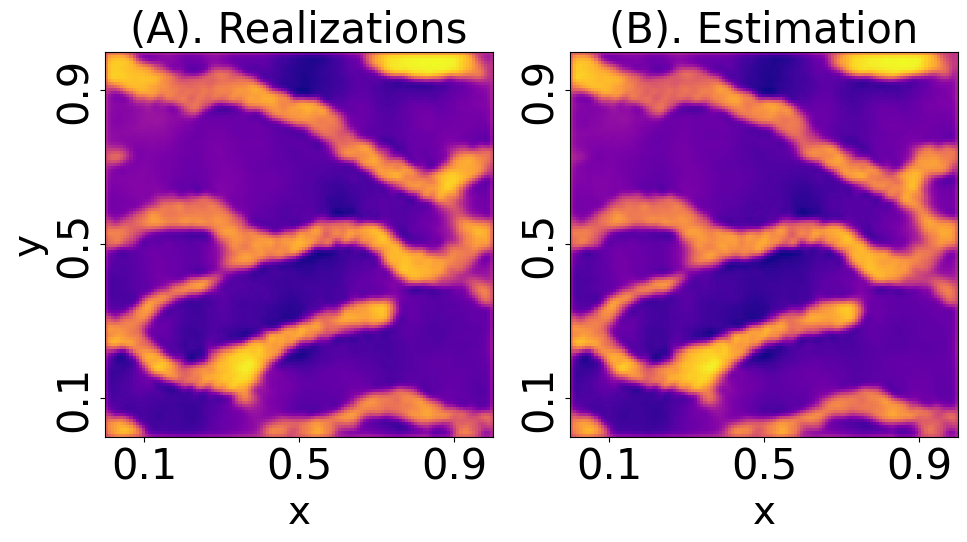

In [ ]:
# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)
print(fid)
#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

logK_true = true_imgs[fid,:]
logK_pred = pred_imgs[fid,:]

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(1,2,figsize=(11,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
im.set_clim((minlK, maxlK))
# ax.set_title('(A). '+field_type+' Field',fontsize=title_size)
ax.set_title('(A). Realizations',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='plasma')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimation',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

# fig.savefig(fig_path+field_type+'_'+pumping_type+'_best.png',bbox_inches="tight")


<ipython-input-18-217f3cc283a7>:18: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.subplots_adjust(left=0.1,


0.9144287109375


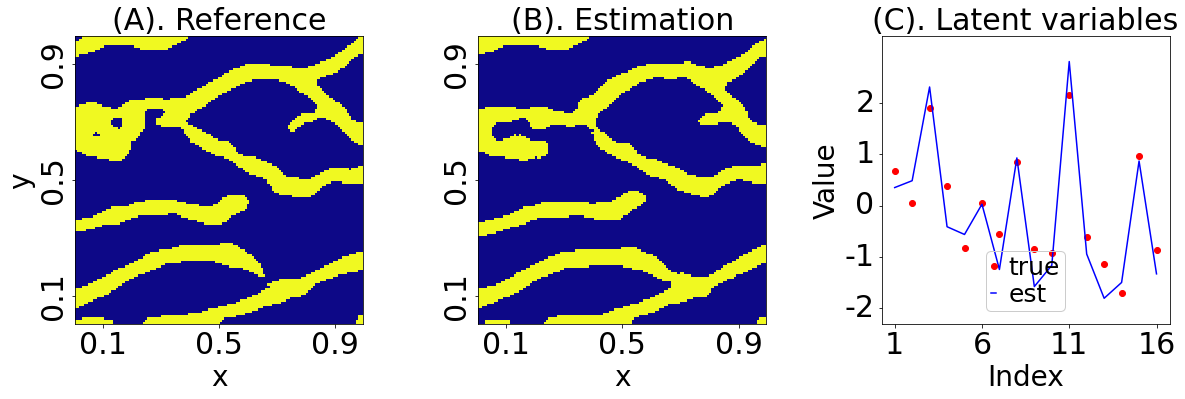

In [ ]:
# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)

#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

logK_true = true_imgs[fid,:]
logK_pred = pred_imgs[fid,:]

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(1,3,figsize=(19,5), gridspec_kw={'width_ratios': [1, 1, 1]},constrained_layout = True)
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
im.set_clim((minlK, maxlK))
ax.set_title('(A). Reference',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='plasma')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimation',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[2]
xplot = np.arange(1, predictions.shape[1]+1)
ax.plot(xplot, X_test[fid,:],'or',label='true')
ax.plot(xplot, predictions[fid,:],'b',label='est')


xticks = np.arange(1, predictions.shape[1]+1,5)
xlabels = np.arange(1, predictions.shape[1]+1,5)
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=axis_tick_font_size,ha='center')

yticks = np.arange(-2, 3)
ylabels = np.arange(-2, 3)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels,fontsize=axis_tick_font_size, ha='right', va='center')

ax.set_ylim([np.floor(min(np.hstack((X_test[fid,:],predictions[fid,:]))))-0.3,
             np.ceil(max(np.hstack((X_test[fid,:],predictions[fid,:]))))+0.3])

ax.set_xlabel('Index',fontsize=axis_label_font_size)
ax.set_ylabel('Value',fontsize=axis_label_font_size)

ax.legend(loc='lower center',ncol=1,prop={'size': legend_fontszie}, framealpha=1, \
          facecolor='none',borderpad=0.2,labelspacing=0.1,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

ax.set_title('(C). Latent variables',fontsize=title_size)

# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

# fig.savefig(fig_path+field_type+'_'+pumping_type+'_best.png',bbox_inches="tight")


59
0.9986931761123882
-2.2332959603445537 -0.14646051566381202
-2.188285266692307 -0.14658147243944308
0.99005126953125


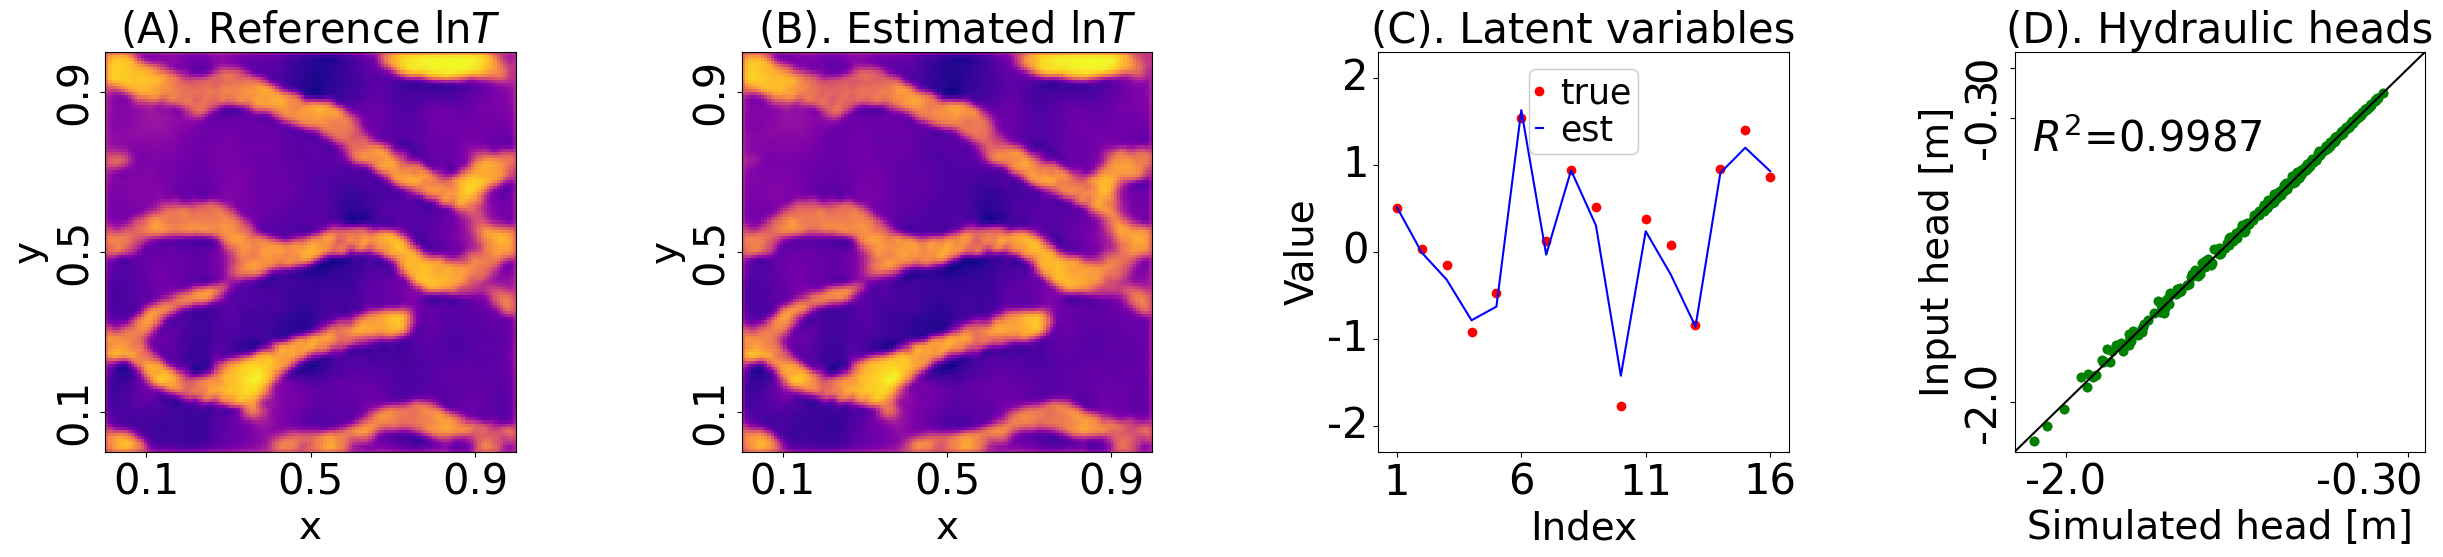

In [ ]:
#set font size
from mpl_toolkits.axes_grid1 import make_axes_locatable

# check_id = np.argmax(acc_list)
fid = np.argmax(acc_list)
print(fid)
#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30
logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(1,4,figsize=(29,5), gridspec_kw={'width_ratios': [1, 1, 1, 1]})
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.55, 
                    hspace=0.4)
axs = axs.flatten()
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
im.set_clim((minlK, maxlK))
ax.set_title('(A). Reference ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

X_star = np.hstack((Xm.flatten()[:,None], Ym.flatten()[:,None]))

# pump_id_list = np.arange(1,25)
# # shift = 40
# shift = -40-256*10
# for i in range(25):
#   texts = 'p'+str(i+1)
#   ax.text(X_star[pump_cell_idx[i]+shift,0], X_star[pump_cell_idx[i]+shift,1], texts, fontsize=15, ha='left', va='top')
# ax.scatter(X_star[pump_cell_idx,0], X_star[pump_cell_idx,1], marker="o", zorder=1, alpha= 1, c='k', s=50, label="pump")
# # ax.scatter(X_star[pump_cell_idx[pump_id_list],0], X_star[pump_cell_idx[pump_id_list],1], marker="o", zorder=1, alpha= 1, c='r', s=40, label="pump")



######################################
######################################
######################################
ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='plasma')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimated ln$T$',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)


ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')





######################################
######################################
######################################
ax = axs[2]
xplot = np.arange(1, predictions.shape[1]+1)
ax.plot(xplot, X_test[fid,:],'or',label='true')
ax.plot(xplot, predictions[fid,:],'b',label='est')

xticks = np.arange(1, predictions.shape[1]+1,5)
xlabels = np.arange(1, predictions.shape[1]+1,5)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabels,fontsize=axis_tick_font_size,ha='center')

yticks = np.arange(-2, 3)
ylabels = np.arange(-2, 3)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels,fontsize=axis_tick_font_size, ha='right', va='center')

ax.set_ylim([np.floor(min(np.hstack((X_test[fid,:],predictions[fid,:]))))-0.3,
             np.ceil(max(np.hstack((X_test[fid,:],predictions[fid,:]))))+0.3])

ax.set_xlabel('Index',fontsize=axis_label_font_size)
ax.set_ylabel('Value',fontsize=axis_label_font_size)

ax.legend(loc='upper center',ncol=1,prop={'size': legend_fontszie}, framealpha=1, \
          facecolor='none',borderpad=0.2,labelspacing=0.1,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

ax.set_title('(C). Latent variables',fontsize=title_size)



######### compute r2 score of the regression: head = inv_head #########
head_true_plot = Y_test[fid,...].flatten()
head_pred_plot = pred_heads[fid,...].flatten()
var_model = np.sum((head_pred_plot - head_true_plot)**2)
var_data = np.sum((head_true_plot-np.mean(head_true_plot))**2)
r2_inverse_head = (var_data-var_model) / var_data
print(r2_inverse_head)


######### plot head scatter: true vs. estimation #########

ax = axs[3]
min_head_true_plot, max_head_true_plot = min(head_true_plot), max(head_true_plot)
min_head_pred_plot, max_head_pred_plot = min(head_pred_plot), max(head_pred_plot)
print(min_head_true_plot, max_head_true_plot)
print(min_head_pred_plot, max_head_pred_plot)
ax.scatter(head_pred_plot,head_true_plot, label='head',color='g')
scaler=1.5
ax.plot([min_head_true_plot*scaler, 0.1], [min_head_true_plot*scaler, 0.1],color='k')
# ax.plot([-1.3, 1.2], [-1.3, 1.2],color='k')

# ticks = [min_head_true_plot, 0.0, max_head_true_plot]
# labels = [min_head_true_plot, 0.0, max_head_true_plot]

ticks = [-2.0,-0,-0.3]
labels = [-2.0,-0,-0.3]

######### x-axis name, ticks and labels #########
ax.set_xlabel('Simulated head [m]',fontsize=axis_label_font_size)
ax.set_xticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_xlim([-2.3,0.1])
######### x-axis name, ticks and labels #########
ax.set_ylabel('Input head [m]',fontsize=axis_label_font_size)
ax.set_yticks(ticks)
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_ylim([-2.3,0.1])

# ######### figure title #########
# ax.set_title('(F). $lnT$ data vs. pred',fontsize=title_size)

######### xfigure text #########
ax.text(-2.2,-0.5, '$R^2$=%.4f'%(r2_inverse_head), fontsize=30,
        bbox={'edgecolor':'w','facecolor':'w'})

ax.set_title('(D). Hydraulic heads', fontsize=title_size)



# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

fig.savefig(fig_path+field_type+'_'+pumping_type+'4plots_best.png',bbox_inches="tight")


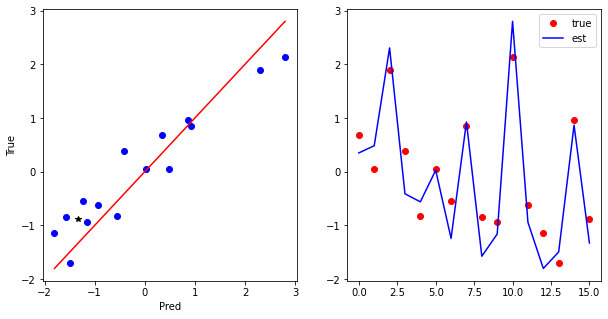

In [ ]:
check_id = fid
fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
plot_max = max(np.max(predictions[check_id]), np.max(X_test[check_id,:]))
plot_min = min(np.min(predictions[check_id]), np.min(X_test[check_id,:]))

ax.plot(predictions[check_id,:15],X_test[check_id,:15],'ob')
ax.plot(predictions[check_id,15:],X_test[check_id,15:],'k*')
ax.plot(np.linspace(plot_min,plot_max,5),np.linspace(plot_min,plot_max,5),'-r')

ax.set_xlabel('Pred')
ax.set_ylabel('True')

ax = axs[1]
xplot = np.arange(predictions.shape[1])
ax.plot(xplot, X_test[check_id,:],'or',label='true')
ax.plot(xplot, predictions[check_id,:],'b',label='est')

ax.legend()

## Wrost Estimate

0.64947509765625


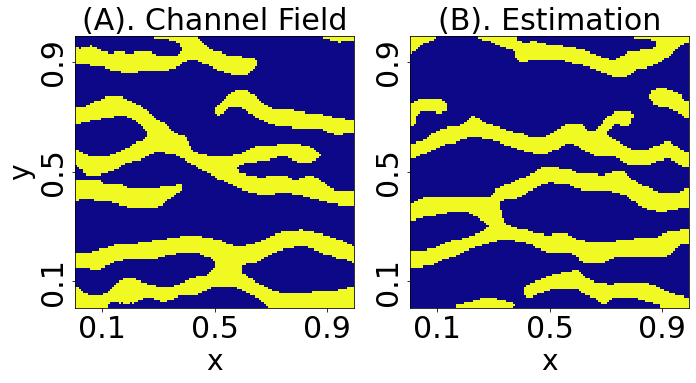

In [ ]:
# check_id = np.argmax(acc_list)
fid = np.argmin(acc_list)

#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

logK_true = true_imgs[fid,:].reshape((nx,ny), order='F')
logK_pred = pred_imgs[fid,:].reshape((nx,ny), order='F')

maxlK, minlK = np.max(logK_true), np.min(logK_true)

fig, axs = plt.subplots(1,2,figsize=(11,5))
ax = axs[0]
im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
im.set_clim((minlK, maxlK))
ax.set_title('(A). '+field_type+' Field',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax = axs[1]
im = ax.pcolormesh(Xm,Ym,logK_pred, cmap='plasma')
# im.set_clim((minlK, maxlK))

ax.set_title('(B). Estimation',fontsize=title_size)

ax.set_xlabel('x',fontsize=axis_label_font_size)
# ax.set_ylabel('y',fontsize=axis_label_font_size)

# cbar = fig.colorbar(im, ax=ax)
# cbar.ax.tick_params(labelsize=colorbar_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

# threshold 10%
thres = 0.15
K_len = maxlK - minlK 

acc = abs(logK_true-logK_pred)/K_len

print(sum(sum(acc<thres))/(nx*ny))

fig.savefig(fig_path+field_type+'_'+pumping_type+'_wrost.png',bbox_inches="tight")


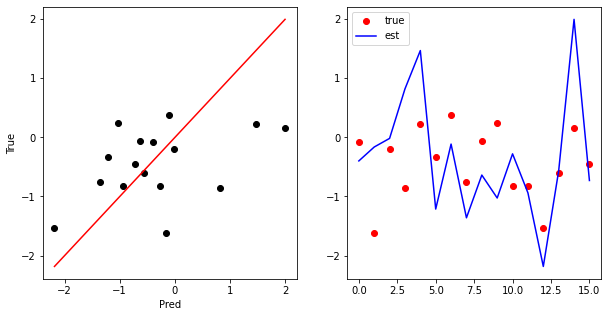

In [ ]:
check_id = fid
fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
plot_max = max(np.max(predictions[check_id,:]), np.max(X_test[check_id,:]))
plot_min = min(np.min(predictions[check_id,:]), np.min(X_test[check_id,:]))

ax.plot(predictions[check_id,:],X_test[check_id,:],'ok')
ax.plot(np.linspace(plot_min,plot_max,5),np.linspace(plot_min,plot_max,5),'-r')

ax.set_xlabel('Pred')
ax.set_ylabel('True')

ax = axs[1]
xplot = np.arange(predictions.shape[1])
ax.plot(xplot, X_test[check_id,:],'or',label='true')
ax.plot(xplot, predictions[check_id,:],'b',label='est')

ax.legend()

## Uncertainty Quantification

In [ ]:
# fid = np.argmax(acc_list)
# n_noises = 20
# # print(Y_test.shape)
# # print(Y_test[fid].shape)
# Noised_Y_test = Y_test[fid] + np.random.normal(0,np.abs(Y_test[fid]*0.05),[n_noises,Y_test[fid].shape[0]])
# # print(Y_test[fid,0:5])

# # print(Noised_Y_test[0:2,0:5])
# predictions = G.predict(Noised_Y_test)

# # print(predictions.shape)

# pred_imgs = conv_gan.generator.predict(predictions)

# for i in range(1):
#   pred_imgs = tfa.image.median_filter2d(pred_imgs,(5,5))

# pred_imgs = pred_imgs[:,:,:,0].numpy()

# split_val = 0.0 #np.mean(rescaled_img)

# pred_imgs[pred_imgs>split_val]=1.0
# pred_imgs[pred_imgs<=split_val]=-1.0

# logK_true = true_imgs[fid]

# acc_list = np.zeros((n_noises,))
# thres = 0.15

# for check_id in range(n_noises):

#   logK_pred = pred_imgs[check_id,:].reshape((nx,ny), order='F')
#   K_len = np.max(logK_true) - np.min(logK_true)

#   res = abs(logK_true-logK_pred)/K_len
#   acc = sum(sum(res<thres))/(nx*ny)

#   acc_list[check_id] = acc

# print("Min Acc: ", np.min(acc_list))
# print("Max Acc: ", np.max(acc_list))
# print("Arg Max Acc: ", np.argmax(acc_list))
# print("Over 90%: ", acc_list[acc_list>=0.9].shape[0])

# print("mean Acc: ", np.mean(acc_list))
# print("std Acc: ", np.std(acc_list))



Min Acc:  0.90716552734375
Max Acc:  0.9217529296875
Arg Max Acc:  10
Over 90%:  20
mean Acc:  0.9144012451171875
std Acc:  0.0035643420790005334


[16 19  6 17  8  0 15  1  9 10]


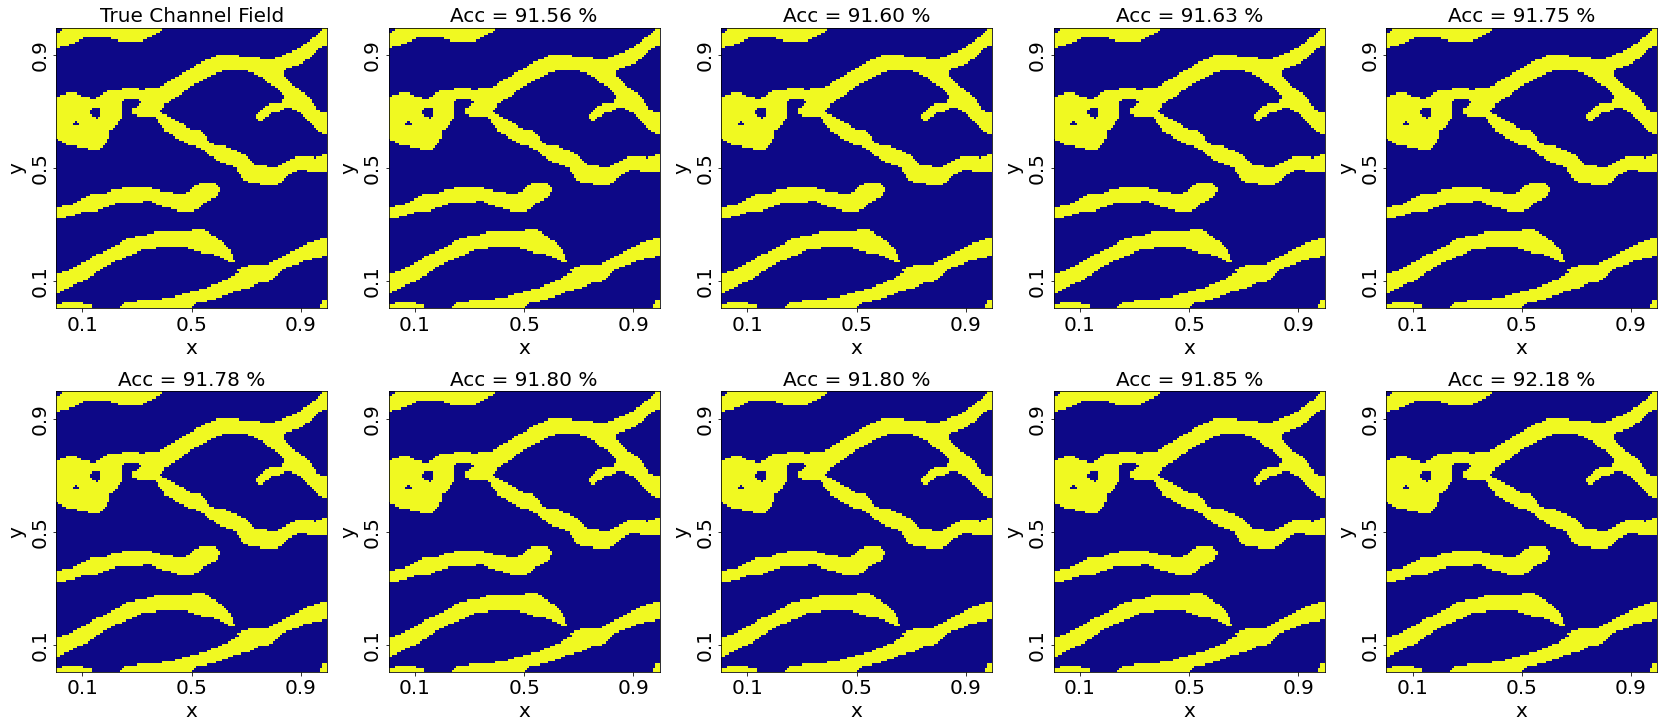

In [ ]:
# #set font size
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# axis_label_font_size = 20
# axis_tick_font_size = 20
# legend_fontszie = 20
# colorbar_font_size = 20
# title_size = 20

# plot_id_list = np.argsort(acc_list)[-10:]

# print(plot_id_list)
# fig, axs = plt.subplots(2, 5, figsize=(23,10),constrained_layout=True) 
# axs = axs.flatten()

# for i in range(axs.shape[0]):
#   ax = axs[i]
#   logK_pred = pred_imgs[plot_id_list[i],:].reshape((nx,ny), order='F')

#   if i == 0:
#     im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
#     ax.set_title('True '+field_type+' Field',fontsize=title_size)

#   else:
#     im = ax.pcolormesh(Xm,Ym,logK_true, cmap='plasma')
#     acc = acc_list[plot_id_list[i]]*100
#     ax_name = "Acc = %.2f %%" % acc
#     ax.set_title(ax_name, fontsize=title_size)

#   im.set_clim((minlK, maxlK))

#   ax.set_xlabel('x',fontsize=axis_label_font_size)
#   ax.set_ylabel('y',fontsize=axis_label_font_size)
# # You can do this easily with a matplotlib AxisDivider.

# # The example from the linked page also works without using subplots:

# # import matplotlib.pyplot as plt
# # from mpl_toolkits.axes_grid1 import make_axes_locatable
# # import numpy as np
    
# # plt.figure()
# # ax = plt.gca()
# # im = ax.imshow(np.arange(100).reshape((10,10)))
    
#   # create an axes on the right side of ax. The width of cax will be 5%
#   # of ax and the padding between cax and ax will be fixed at 0.05 inch.
#   # divider = make_axes_locatable(ax)
#   # cax = divider.append_axes("right", size="10%", pad=0.05)
#   # cbar = fig.colorbar(im, cax=cax)

#   # cbar = fig.colorbar(im, ax=ax, fraction=0.005, shrink=1.0)
#   # cbar.ax.tick_params(labelsize=colorbar_font_size)

#   ticks = [-0.4, 0.0, 0.4]

#   labels = [0.1, 0.5, 0.9]
#   ax.set_xticks(ticks)
#   ax.set_yticks(ticks)
#   ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
#   ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

## Save Model

In [ ]:
# G.save('./head_to_latent_model/'+field_type+'_'+pumping_type+'_5000')

# G.save('./head_to_latent_model/'+'Channel_Gaussian_'+pumping_type+'_5000')